In [1]:
import nbdev.showdoc

In [2]:
#hide
#default_exp export
#default_cls_lvl 3
from nbdev.showdoc import show_doc

In [3]:
from nbdev.imports import *
from fastcore.script import *
from fastcore.foundation import *
from keyword import iskeyword
import nbformat

# Export to scala sbt project 

> The functions that transform notebooks in a library (nearly 1:1 translation from nbdev 00_export.ipynb, with the goal of transforming notebooks using Jupyter Scala kernel (https://almond.sh) into importable, testable, and well documented Scala files. 

The most important function defined in this module is `notebooks2script`, so you may want to jump to it before scrolling though the rest, which explain the details behind the scenes of the conversion from notebooks to library. The main things to remember are:
- put `# export` on each cell you want exported
- put `# exports` on each cell you want exported with the source code shown in the docs 
- put `# exporti` on each cell you want exported without it being added to `__all__`, and without it showing up in the docs.
- one cell should contain `# default_exp` followed by the name of the module (with points for submodules and without the py extension) everything should be exported in (if one specific cell needs to be exported in a different module, just indicate it after `#export`: `#export special.module`)
- all left members of an equality, functions and classes will be exported and variables that are not private will be put in the `__all__` automatically
- to add something to `__all__` if it's not picked automatically, write an exported cell with something like `#add2all "my_name"`

## Basic foundations

For bootstrapping `nbdev` we have a few basic foundations defined in <code>imports</code>, which we test a show here. First, a simple config file class, `Config` that read the content of your `settings.ini` file and make it accessible:

In [4]:
show_doc(Config, title_level=3)

<h3 id="Config" class="doc_header"><code>Config</code><a href="https://github.com/fastai/fastcore/tree/master/fastcore/foundation.py#L252" class="source_link" style="float:right">[source]</a></h3>

> <code>Config</code>(**`cfg_name`**=*`'settings.ini'`*)

Reading and writing `settings.ini`

In [5]:
cfg = Config(cfg_name='settings.ini')
test_eq(cfg.lib_name, 'chisel-nbdev')
test_eq(cfg.git_url, "https://github.com/ucsc-vama/chisel-nbdev")
test_eq(cfg.path("lib_path"), Path.cwd().parent/'nbdev')
test_eq(cfg.path("nbs_path"), Path.cwd())
# test_eq(cfg.path("doc_path"), Path.cwd().parent/'docs')
# test_eq(cfg.custom_sidebar, 'False')

## Reading a notebook

### What's a notebook?

A jupyter notebook is a json file behind the scenes. We can just read it with the json module, which will return a nested dictionary of dictionaries/lists of dictionaries, but there are some small differences between reading the json and using the tools from `nbformat` so we'll use this one.

In [6]:
#export
def read_nb(fname):
    "Read the notebook in `fname`."
    with open(Path(fname),'r', encoding='utf8') as f: return nbformat.reads(f.read(), as_version=4)

`fname` can be a string or a pathlib object.

In [7]:
test_nb = read_nb('test.ipynb')

The root has four keys: `cells` contains the cells of the notebook, `metadata` some stuff around the version of python used to execute the notebook, `nbformat` and `nbformat_minor` the version of nbformat. 

In [8]:
test_nb.keys()

dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])

In [9]:
test_nb['metadata']

{'kernelspec': {'display_name': 'Scala', 'language': 'scala', 'name': 'scala'},
 'language_info': {'codemirror_mode': 'text/x-scala',
  'file_extension': '.scala',
  'mimetype': 'text/x-scala',
  'name': 'scala',
  'nbconvert_exporter': 'script',
  'version': '2.12.10'}}

In [10]:
f"{test_nb['nbformat']}.{test_nb['nbformat_minor']}"

'4.4'

The cells key then contains a list of cells. Each one is a new dictionary that contains entries like the type (code or markdown), the source (what is written in the cell) and the output (for code cells).

In [11]:
test_nb['cells'][0]

{'cell_type': 'markdown',
 'metadata': {},
 'source': '### Call the load_ivy script.\nLocated in the source folder, the load_ivy.sc script will use ammonite to download snapshots of the chisel libraries, to be cached on your system. This is necessary for EVERY chisel notebook so we can then import our chisel libraries like we would in an SBT project structure.'}

### Finding patterns

The following functions are used to catch the flags used in the code cells.

In [12]:
#export
def check_re(cell, pat, code_only=True):
    "Check if `cell` contains a line with regex `pat`"
    if code_only and cell['cell_type'] != 'code': return
    if isinstance(pat, str): pat = re.compile(pat, re.IGNORECASE | re.MULTILINE)
    return pat.search(cell['source'])

`pat` can be a string or a compiled regex. If `code_only=True`, this function ignores non-code cells, such as markdown.

In [13]:
cell = test_nb['cells'][1].copy()
# print(cell)
assert check_re(cell, '//export') is not None
assert check_re(cell, re.compile('//export')) is not None
assert check_re(cell, '# bla') is None
cell['cell_type'] = 'markdown'
assert check_re(cell, '//export') is None # don't export markdown
assert check_re(cell, '//export', code_only=False) is not None # unless specified

In [14]:
#export
def check_re_multi(cell, pats, code_only=True):
    "Check if `cell` contains a line matching any regex in `pats`, returning the first match found"
    return L(pats).map_first(partial(check_re, cell, code_only=code_only))

In [15]:
cell = test_nb['cells'][1].copy()
cell['source'] = "a b c"
# print(cell)
assert check_re(cell, 'a') is not None
assert check_re(cell, 'd') is None
# show that searching with patterns ['d','b','a'] will match 'b'
# i.e. 'd' is not found and we don't search for 'a'
assert check_re_multi(cell, ['d','b','a']).span() == (2,3)

In [16]:
#export
def _mk_flag_re(body, n_params, comment):
    "Compiles a regex for finding nbdev flags"
    assert body!=True, 'magics no longer supported'
    prefix = r"\s*\//\s*" # scala style comment "//" is prefix
    param_group = ""
    if n_params == -1: param_group = r"[ \t]+(.+)"
    if n_params == 1: param_group = r"[ \t]+(\S+)"
    if n_params == (0,1): param_group = r"(?:[ \t]+(\S+))?"
    return re.compile(rf"""
# {comment}:
^           # beginning of line (since re.MULTILINE is passed)
{prefix}
{body}
{param_group}
[ \t]*       # any number of spaces and/or tabs
$            # end of line (since re.MULTILINE is passed)
""", re.MULTILINE | re.VERBOSE)

This function returns a regex object that can be used to find nbdev flags in multiline text
- `body` regex fragment to match one or more flags,
- `n_params` number of flag parameters to match and catch (-1 for any number of params; `(0,1)` for 0 for 1 params),
- `comment` explains what the compiled regex should do.

In [17]:
#hide
re_blank_test = _mk_flag_re('export[si]?', 0, "test") # 0:
re_mod_test = _mk_flag_re('export[si]?', 1, "test")
re_opt_test = _mk_flag_re('export[si]?', (0,1), "test")
for f in ['export', 'exports', 'exporti']:
    cell = nbformat.v4.new_code_cell(f'//{f}  \n some code')
    assert check_re(cell, re_blank_test) is not None
    assert check_re(cell, re_mod_test) is None
    assert check_re(cell, re_opt_test) is not None
    test_eq(check_re(cell, re_opt_test).groups()[0], None)
    cell.source = f'//{f} special.module \n some code'
    assert check_re(cell, re_blank_test) is None
    assert check_re(cell, re_mod_test) is not None
    test_eq(check_re(cell, re_mod_test).groups()[0], 'special.module')
    assert check_re(cell, re_opt_test) is not None
    test_eq(check_re(cell, re_opt_test).groups()[0], 'special.module')

In [18]:
#export
_re_blank_export = _mk_flag_re("export[si]?", 0,
    "Matches any line with //export, //exports or //exporti without any module name")

In [19]:
#export
_re_mod_export = _mk_flag_re("export[si]?", 1,
    "Matches any line with //export, //exports or //exporti with a module name and catches it in group 1")

In [20]:
#export
_re_internal_export = _mk_flag_re("exporti", (0,1),
    "Matches any line with //exporti with or without a module name")

In [21]:
#exporti
def _is_external_export(tst):
    "Check if a cell is an external or internal export. `tst` is an re match"
    return _re_internal_export.search(tst.string) is None

In [22]:
#export
def is_export(cell, default):
    "Check if `cell` is to be exported and returns the name of the module to export it if provided"
    tst = check_re(cell, _re_blank_export)
    if tst:
        if default is None:
            print(f"No export destination, ignored:\n{cell['source']}")
        return default, _is_external_export(tst)
    tst = check_re(cell, _re_mod_export)
    if tst: return os.path.sep.join(tst.groups()[0].split('.')), _is_external_export(tst)
    else: return None

`is_export` returns;
- a tuple of ("module name", "external boolean" (`False` for an internal export)) if `cell` is to be exported or 
- `None` if `cell` will not be exported.

The cells to export are marked with `//export`/`//exporti`/`//exports`, potentially with a module name where we want it exported. The default module is given in a cell of the form `//default_exp bla` inside the notebook (usually at the top), though in this function, it needs the be passed (the final script will read the whole notebook to find it).
- a cell marked with `//export`/`//exporti`/`//exports` will be exported to the default module
- an exported cell marked with `special.module` appended will be exported in `special.module` (located in `lib_name/special/module.py`)
- a cell marked with `//export` will have its signature added to the documentation
- a cell marked with `//exports` will additionally have its source code added to the documentation
- a cell marked with `//exporti` will not show up in the documentation, and will also not be added to `__all__`.

In [23]:
cell = test_nb['cells'][1].copy()
test_eq(is_export(cell, 'export'), ('export', True))
cell['source'] = "// exports"
test_eq(is_export(cell, 'export'), ('export', True))
cell['source'] = "// exporti"
test_eq(is_export(cell, 'export'), ('export', False))
cell['source'] = "// export mod"
test_eq(is_export(cell, 'export'), ('mod', True))

In [24]:
#hide
cell['source'] = "// export mod.file"
test_eq(is_export(cell, 'export'), (f'mod{os.path.sep}file', True))
cell['source'] = "// exporti mod.file"
test_eq(is_export(cell, 'export'), (f'mod{os.path.sep}file', False))
cell['source'] = "// expt mod.file"
assert is_export(cell, 'export') is None
cell['source'] = "// exportmod.file"
assert is_export(cell, 'export') is None
cell['source'] = "// exportsmod.file"
assert is_export(cell, 'export') is None
cell['source'] = "// exporti mod file"
assert is_export(cell, 'export') is None

In [25]:
#export
_re_default_exp = _mk_flag_re('default_exp', 1, "Matches any line with //default_exp with a module name")

In [26]:
#export
def find_default_export(cells):
    "Find in `cells` the default export module."
    res = L(cells).map_first(check_re, pat=_re_default_exp)
    return res.groups()[0] if res else None

Stops at the first cell containing `// default_exp` (if there are several) and returns the value behind. Returns `None` if there are no cell with that code.

In [27]:
test_eq(find_default_export(test_nb['cells']), 'test')
assert find_default_export(test_nb['cells'][2:]) is None

In [28]:
#hide
mods = [f'mod{i}' for i in range(3)]
cells = [{'cell_type': 'code', 'source': f'//default_exp {mod}'} for mod in mods]
for i, mod in enumerate(mods): test_eq(mod, find_default_export(cells[i:]))

### Listing all exported objects

Until now the above code has been verbatim to the ```00_export.ipynb``` from nbdev minus changes to regexes swapping '#' to '//'.
Now Scala syntax parsing is required as well as a target build infrastructure (sbt, mill, or Ammonite scripts).

For documentation we need to extract out the names of our classes, objects, methods, etc including:
- def 
- object
- class | abstract class | 
- case class
- trait
- sealed trait
- abstract
- package
- override
- private?
- implicit
- protected
- import
- extends 
- final 

In [29]:
#export
_re_class_func_def = re.compile(r"""
# Catches any function or class or trait or case class or object definition
(?:abstract\s+class|case\s+class|class|object|trait|sealed\s+trait|implicit\s+def|def)  # Non-catching group for def or class
\s+            # One whitespace or more
([^\(\s]+)     # Catching group with any character except an opening parenthesis or a whitespace (name)
\s*            # Any number of whitespace
(?:\(|:|{)       # Non-catching group with either an opening parenthesis or a : (classes don't need ())
""", re.MULTILINE | re.VERBOSE)

In [30]:
#hide
test_eq(_re_class_func_def.search(" class Class{ }").groups(), ('Class',))
test_eq(_re_class_func_def.search("  class Class(w: Int) extends Module {}").groups(), ('Class',))
test_eq(_re_class_func_def.search("abstract  class  Class(w: Int) {}").groups(), ('Class',))
test_eq(_re_class_func_def.search("case  class Class(w: Int)").groups(), ('Class',))
test_eq(_re_class_func_def.search("object Test{}").groups(), ('Test',))
test_eq(_re_class_func_def.search("trait  Test{} ").groups(), ('Test',))
test_eq(_re_class_func_def.search("sealed  trait  Test{} ").groups(), ('Test',))
test_eq(_re_class_func_def.search("def func(a: Int): Int = {}").groups(), ('func',))
test_eq(_re_class_func_def.search("def func(a: Int) = {}").groups(), ('func',))
test_eq(_re_class_func_def.search("implicit def func(a: Int) = {}").groups(), ('func',))

In [31]:
#export
def export_names(code):
    "Find the names of objects, functions or classes defined in `code` that are exported."
    names = _re_class_func_def.findall(code)
    return names

This function finds all of the function/class/object names.

In [32]:
test_eq(export_names("def my_func(x: Int): Unit = {\n\tprint(x)\n}\n class MyClass(){}"), ["my_func", "MyClass"])

In [33]:
#hide
#Indented funcs are ignored (funcs inside a class)
test_eq(export_names("  def my_func(x)= x + 1\n  pass\nclass MyClass(){}"), ["my_func", "MyClass"])
test_eq(export_names("  def my_func(x)= x + 1\n  pass\nobject MyClass(){}"), ["my_func", "MyClass"])
test_eq(export_names("  implicit def my_func(x)= x + 1\n  pass\nobject MyClass(){}"), ["my_func", "MyClass"])

test_eq(export_names("  case class Datastruct(x)= x + 1\n  pass\n abstract class MyClass(){}"), ["Datastruct", "MyClass"])
test_eq(export_names("  seal trait Equal(x)= x + 1\n  pass\n trait NotEqual{}"), ["Equal", "NotEqual"])


#trailing spaces
test_eq(export_names("def my_func () = {}\n  pass\nclass MyClass():"), ["my_func", "MyClass"])

#class without parenthesis
test_eq(export_names("def my_func ()= Unit()\n  pass\nclass MyClass {}"), ["my_func", "MyClass"])

#try, except and other keywords should not be picked up (these can look like object def with type annotation)
test_eq(export_names("try:\n    a=1\nexcept:\n    b=2"), [])
test_eq(export_names("try:\n    this_might_work\nexcept:\n    b=2"), [])

todo need to handle imports in the form:
```scala
    import $file.ToImport, ToImport._
```

where ToImport.sc is the name of the module we extracted code to.

## Create the library

### Saving an index

To be able to build back a correspondence between functions and the notebooks they are defined in, we need to store an index. It's done in the private module <code>_nbdev</code> inside your library, and the following function are used to define it.

In [34]:
#export
_re_index_custom = re.compile(r'def custom_doc_links\(name\):(.*)$', re.DOTALL)

In [35]:
#export
def reset_nbdev_module():
    "Create a skeleton for <code>_nbdev</code>"
    fname = Config().path("lib_path")/'_nbdev.py'
    fname.parent.mkdir(parents=True, exist_ok=True)
    sep = '\n'* (int(Config().get('cell_spacing', '1'))+1)
    if fname.is_file():
        with open(fname, 'r') as f: search = _re_index_custom.search(f.read())
    else: search = None
    prev_code = search.groups()[0] if search is not None else ' return None\n'
    with open(fname, 'w') as f:
        f.write(f"# AUTOGENERATED BY NBDEV! DO NOT EDIT!")
        f.write('\n\n__all__ = ["index", "modules", "custom_doc_links", "git_url"]')
        f.write('\n\nindex = {}')
        f.write('\n\nmodules = []')
        f.write(f'\n\ndoc_url = "{Config().doc_host}{Config().doc_baseurl}"')
        f.write(f'\n\ngit_url = "{Config().git_url}"')
        f.write(f'{sep}def custom_doc_links(name):{prev_code}')

In [36]:
#export
class _EmptyModule():
    def __init__(self):
        self.index,self.modules = {},[]
        self.doc_url,self.git_url = f"{Config().doc_host}{Config().doc_baseurl}",Config().git_url

    def custom_doc_links(self, name): return None

In [37]:
#export
def get_nbdev_module():
    "Reads <code>_nbdev</code>"
    try:
        spec = importlib.util.spec_from_file_location(f"{Config().lib_name}._nbdev", Config().path("lib_path")/'_nbdev.py')
        mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(mod)
        return mod
    except: return _EmptyModule()

In [38]:
#export
_re_index_idx = re.compile(r'index\s*=\s*{[^}]*}')
_re_index_mod = re.compile(r'modules\s*=\s*\[[^\]]*\]')

In [39]:
#export
def save_nbdev_module(mod):
    "Save `mod` inside <code>_nbdev</code>"
    fname = Config().path("lib_path")/'_nbdev.py'
    with open(fname, 'r') as f: code = f.read()
    t = r',\n         '.join([f'"{k}": "{v}"' for k,v in mod.index.items()])
    code = _re_index_idx.sub("index = {"+ t +"}", code)
    t = r',\n           '.join(['"' + f.replace('\\','/') + '"' for f in mod.modules])
    code = _re_index_mod.sub(f"modules = [{t}]", code)
    with open(fname, 'w') as f: f.write(code)

this creates the _nvdev.py file.

In [40]:
#hide
ind,ind_bak = Config().path("lib_path")/'_nbdev.py',Config().path("lib_path")/'_nbdev.bak'
if ind.exists(): shutil.move(ind, ind_bak)
try:
    reset_nbdev_module()
    mod = get_nbdev_module()
    test_eq(mod.index, {})
    test_eq(mod.modules, [])

    mod.index = {'foo':'bar'}
    mod.modules.append('lala.bla')
    save_nbdev_module(mod)

    mod = get_nbdev_module()
    test_eq(mod.index, {'foo':'bar'})
    test_eq(mod.modules, ['lala.bla'])
finally:
    if ind_bak.exists(): shutil.move(ind_bak, ind)

### Create the modules

`return_type` tells us if the tuple returned will contain `list`s of lines or `str`ings with line breaks. 

We treat the first comment line as a flag
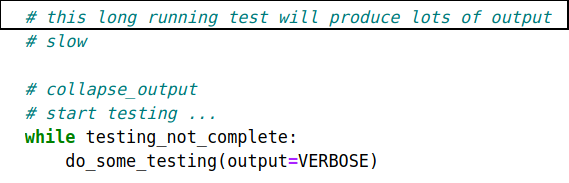

In [41]:
#export
def split_flags_and_code(cell, return_type=list):
    "Splits the `source` of a cell into 2 parts and returns (flags, code)"
    code_lines = cell['source'].split('\n')
    split_pos = 0 if code_lines[0].strip().startswith('//') else -1
    for i, line in enumerate(code_lines):
        if not line.startswith('//') and line.strip(): break
    split_pos+=1
    res = code_lines[:split_pos], code_lines[split_pos:]
    if return_type is list: return res
    return tuple('\n'.join(r) for r in res)

In [42]:
def _test_split_flags_and_code(expected_flags, expected_code):
    cell = nbformat.v4.new_code_cell('\n'.join(expected_flags + expected_code))
    test_eq((expected_flags, expected_code), split_flags_and_code(cell))
    expected=('\n'.join(expected_flags), '\n'.join(expected_code))
    test_eq(expected, split_flags_and_code(cell, str))
    
_test_split_flags_and_code([
    '//export'],
    ['// TODO: write this function',
    'def func(x) = ???'])

In [43]:
#export
def create_mod_file(fname, nb_path, bare=False):
    "Create a module file for `fname`."
    bare = str(Config().get('bare', bare)) == 'True'
    fname.parent.mkdir(parents=True, exist_ok=True)
    file_path = os.path.relpath(nb_path, Config().config_file.parent).replace('\\', '/')
#     print(f"in create_mod_file, file_path: {file_path}")
    with open(fname, 'w') as f:
        if not bare: f.write(f"// AUTOGENERATED! DO NOT EDIT! File to edit: {file_path} (unless otherwise specified).")
#         f.write('\n\n__all__ = []')

A new module filename is created each time a notebook has a cell marked with `#default_exp`. In your collection of notebooks, you should only have one notebook that creates a given module since they are re-created each time you do a library build (to ensure the library is clean). Note that any file you create manually will never be overwritten (unless it has the same name as one of the modules defined in a `#default_exp` cell) so you are responsible to clean up those yourself.

`fname` is the notebook that contained the `#default_exp` cell.

In [44]:
#export
def create_mod_files(files, to_dict=False, bare=False):
    "Create mod files for default exports found in `files`"
    modules = []
    for f in files:
        fname = Path(f)
#         print(f"in create_mod_files, {fname}")
        nb = read_nb(fname)
        default = find_default_export(nb['cells'])
        if default is not None:
            default = os.path.sep.join(default.split('.'))
            modules.append(default)
            if not to_dict:
                create_mod_file(Config().path("lib_path")/f'{default}.sc', Config().path("nbs_path")/f'{fname}', bare=bare)
    return modules

Create module files for all `#default_export` flags found in `files` and return a list containing the names of modules created. 

Note: The number if modules returned will be less that the number of files passed in if files do not `#default_export`.

By creating all module files before calling `_notebook2script`, the order of execution no longer matters - so you can now export to a notebook that is run "later".

You might still have problems when
- converting a subset of notebooks or
- exporting to a module that does not have a `#default_export` yet

in which case `_notebook2script` will print warnings like;
```
Warning: Exporting to "core.py" but this module is not part of this build
```

If you see a warning like this
- and the module file (e.g. "core.py") does not exist, you'll see a `FileNotFoundError`
- if the module file exists, the exported cell will be written - even if the exported cell is already in the module file

In [45]:
#export
def _notebook2script(fname, modules, silent=False, to_dict=None, bare=False):
    "Finds cells starting with `//export` and puts them into a module created by `create_mod_files`"
    bare = str(Config().get('bare', bare)) == 'True'
    if os.environ.get('IN_TEST',0): return  # don't export if running tests
    sep = '\n'* (int(Config().get('cell_spacing', '1'))+1)
    fname = Path(fname)
    nb = read_nb(fname)
    default = find_default_export(nb['cells'])
    if default is not None:
        default = os.path.sep.join(default.split('.'))
    mod = get_nbdev_module()
    exports = [is_export(c, default) for c in nb['cells']]
    cells = [(i,c,e) for i,(c,e) in enumerate(zip(nb['cells'],exports)) if e is not None]
    for i,c,(e,a) in cells:
        if e not in modules: print(f'Warning: Exporting to "{e}.sc" but this module is not part of this build')
        fname_out = Config().path("lib_path")/f'{e}.sc'
        if bare: orig = "\n"
        else: orig = (f'// {"" if a else "Internal "}C' if e==default else f'// Comes from {fname.name}, c') + 'ell\n'
        flag_lines,code_lines = split_flags_and_code(c)
#         code_lines = _deal_import(code_lines, fname_out)
        code = sep + orig + '\n'.join(code_lines)
        names = export_names(code)
        flags = '\n'.join(flag_lines)
#         extra,code = extra_add(flags, code)
#         code = _from_future_import(fname_out, flags, code, to_dict)
#         if a:
#             if to_dict is None: _add2all(fname_out, [f"'{f}'" for f in names if '.' not in f and len(f) > 0] + extra)
        mod.index.update({f: fname.name for f in names})
        code = re.sub(r' +$', '', code, flags=re.MULTILINE)
        if code != sep + orig[:-1]:
            if to_dict is not None: to_dict[e].append((i, fname, code))
            else:
                with open(fname_out, 'a', encoding='utf8') as f: f.write(code)
        if f'{e}.sc' not in mod.modules: mod.modules.append(f'{e}.sc')
    save_nbdev_module(mod)

    if not silent: print(f"Converted {fname.name}.")
    return to_dict

In [47]:
#hide
if not os.environ.get('IN_TEST',0):
    modules = create_mod_files(glob.glob('test.ipynb'))
    _notebook2script('test.ipynb', modules)

Converted test.ipynb.


In [49]:
#hide
with open(Config().path("lib_path")/('test.sc')) as f: l = f.readline()
test_eq(l, '// AUTOGENERATED! DO NOT EDIT! File to edit: nbs/test.ipynb (unless otherwise specified).\n')

In [50]:
#export
_re_baseurl = re.compile('^baseurl\s*:.*$', re.MULTILINE)

In [51]:
#export
def update_baseurl():
    "Add or update `baseurl` in `_config.yml` for the docs"
    fname = Config().path("doc_path")/'_config.yml'
    if not fname.exists(): return
    with open(fname, 'r') as f: code = f.read()
    if _re_baseurl.search(code) is None: code = code + f"\nbaseurl: {Config().doc_baseurl}"
    else: code = _re_baseurl.sub(f"baseurl: {Config().doc_baseurl}", code)
    with open(fname, 'w') as f: f.write(code)

In [52]:
#export
#hide
def _get_paths(pth:str, names:list): return [Path(pth)/n for n in names if '/.' not in pth] 

In [53]:
#export
def nbglob(fname=None, recursive=False) -> L:
    "Find all notebooks in a directory given a glob. Ignores hidden directories and filenames starting with `_`"
    fname = Path(fname) if fname else Config().path("nbs_path")
#     print(f'fname: {fname}')
    if recursive: fls = L(os.walk(fname)).map(lambda x: _get_paths(x[0], x[2])).concat()
    else: fls = fname.glob('*.ipynb')
#     for i, f in enumerate(fls):
#         print(f'file {i}: {f}')
    return L([f for f in fls if not f.name.startswith('_') and f.name.endswith('.ipynb')])

In [55]:
f = Config().path("nbs_path") # works for recursive = true
# f = Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs') # works for recursive = true
# f = Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/test.ipynb')
# fs = f.glob('')
# [file for file in fs]
# nbglob(f)
nbglob(f, recursive=True)
# nbglob()

(#5) [Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/ToImport.ipynb'),Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/import_chisel_mod.ipynb'),Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/import_composed_mod.ipynb'),Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/export_scala.ipynb'),Path('/Users/jasonvranek/code/notebooks/chisel-nbdev/nbs/test.ipynb')]

In [56]:
assert not nbglob(recursive=True).filter(lambda x: '.ipynb_checkpoints' in str(x))

In [57]:
#export
def notebook2script(fname=None, silent=False, to_dict=False, bare=False, recursive=False):
    "Convert notebooks matching `fname` to modules"
    # initial checks
    if os.environ.get('IN_TEST',0): return  # don't export if running tests
    if fname is None:
        reset_nbdev_module()
#         update_version()
        update_baseurl()
    files = nbglob(fname=fname, recursive=recursive)
    d = collections.defaultdict(list) if to_dict else None
    modules = create_mod_files(files, to_dict, bare=bare)
    for f in sorted(files): d = _notebook2script(f, modules, silent=silent, to_dict=d, bare=bare)
    return d

Finds cells starting with `#export` and puts them into the appropriate module. If `fname` is not specified, this will convert all notebook not beginning with an underscore in the `nb_folder` defined in `setting.ini`. Otherwise `fname` can be a single filename or a glob expression.

`silent` makes the command not print any statement and `to_dict` is used internally to convert the library to a dictionary. 

In [60]:
#hide
notebook2script()

Converted ToImport.ipynb.
Converted export_scala.ipynb.
Converted import_chisel_mod.ipynb.
Converted import_composed_mod.ipynb.
Converted test.ipynb.
